In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras

from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GRU, Dropout, BatchNormalization, SimpleRNN, Bidirectional
#from keras.layers import , LSTM, MaxPooling1D, MaxPool2D, Conv1D, Conv2D, 
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils

In [3]:
trainpath = '../data/training/'
valpath = '../data/validation/'

mfcc_files = [trainpath + f for f in listdir(trainpath) if 'mfcc.pkl' in f]
target_files = [trainpath + f for f in listdir(trainpath) if 'target.pkl' in f]

mfcc_val = [valpath + f for f in listdir(valpath) if 'mfcc.pkl' in f]
target_val = [valpath + f for f in listdir(valpath) if 'target.pkl' in f]

mfcc_files.sort()
target_files.sort()
mfcc_val.sort()
target_val.sort()

In [4]:
def reload(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [5]:
train_mfcc_reloaded = [reload(f) for f in mfcc_files]
train_target_reloaded = [reload(f) for f in target_files]

val_mfcc_reloaded = [reload(f) for f in mfcc_val]
val_target_reloaded = [reload(f) for f in target_val]

In [6]:
X_train = np.concatenate(train_mfcc_reloaded)
y_train = np.concatenate(train_target_reloaded)
X_val = np.concatenate(val_mfcc_reloaded)
y_val = np.concatenate(val_target_reloaded)

In [7]:
# https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
enocded_y_val = encoder.transform(y_val)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_y_train)
dummy_y_val = np_utils.to_categorical(enocded_y_val)

In [8]:
X_val = X_val.reshape(X_val.shape[0] // 157 // 10, 10, 157)

In [9]:
X_vtrain, X_vtest, y_vtrain, y_vtest = train_test_split(X_val, dummy_y_val, random_state=552)

In [10]:
X = np.concatenate([X_train, X_vtrain])
y = np.concatenate([dummy_y_train, y_vtrain])

In [16]:
X = X.reshape(X.shape[0], 10, 157, 1)
X_vtest = X_vtest.reshape(X_vtest.shape[0], 10, 157, 1)

In [12]:
y.shape

(84506, 5)

In [20]:
model = Sequential()
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [21]:
earlystop = EarlyStopping(patience=5)

In [22]:
history = model.fit(
    x=X,
    y=y,
    validation_data=(X_vtest, y_vtest),
    callbacks=[earlystop],
    epochs=50
)

Epoch 1/50
2641/2641 [==============================] - 9s 3ms/step - loss: 1.5423 - acc: 0.2899 - val_loss: 1.5325 - val_acc: 0.3304
Epoch 2/50
2641/2641 [==============================] - 8s 3ms/step - loss: 1.4313 - acc: 0.3749 - val_loss: 1.5092 - val_acc: 0.3279
Epoch 3/50
2641/2641 [==============================] - 7s 3ms/step - loss: 1.3923 - acc: 0.4078 - val_loss: 1.4876 - val_acc: 0.3485
Epoch 4/50
2641/2641 [==============================] - 7s 3ms/step - loss: 1.3628 - acc: 0.4260 - val_loss: 1.4981 - val_acc: 0.3383
Epoch 5/50
2641/2641 [==============================] - 7s 3ms/step - loss: 1.3456 - acc: 0.4346 - val_loss: 1.5228 - val_acc: 0.3126
Epoch 6/50
2641/2641 [==============================] - 7s 3ms/step - loss: 1.3337 - acc: 0.4399 - val_loss: 1.4734 - val_acc: 0.3487
Epoch 7/50
2641/2641 [==============================] - 7s 3ms/step - loss: 1.3200 - acc: 0.4484 - val_loss: 1.4781 - val_acc: 0.3618
Epoch 8/50
2641/2641 [==============================] - 7s 3ms

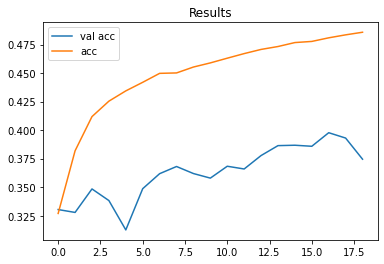

In [23]:
# plot
plt.plot(history.history['val_acc'], label = 'val acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend()
plt.title('Results');

In [24]:
y_out = np.apply_along_axis(np.argmax, axis=1, arr=y_vtest)

In [25]:
cm = confusion_matrix(y_out, model.predict_classes(X_vtest))

In [26]:
cm

array([[ 553,  109,  361,  614,   93],
       [ 582,  368,  197,  530,   47],
       [ 331,   97,  594,  713,   78],
       [ 100,   86,   89, 1401,   55],
       [ 284,  147,  131,  827,  360]])

In [27]:
cm.sum(axis=1, keepdims=True)

array([[1730],
       [1724],
       [1813],
       [1731],
       [1749]])

In [28]:
cm_norm = np.true_divide(cm, cm.sum(axis=1, keepdims=True))

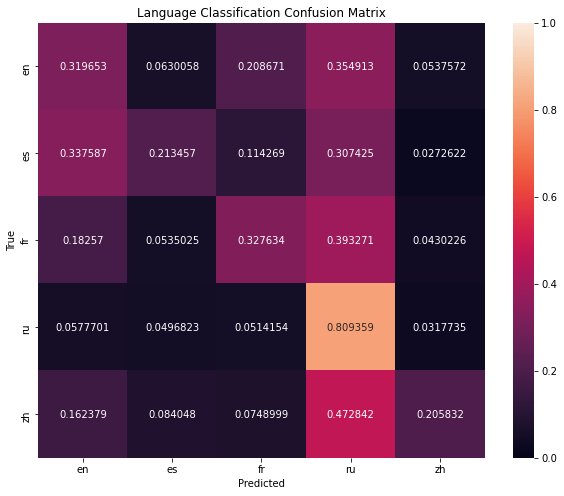

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, vmin=0, vmax=1, fmt='g', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Language Classification Confusion Matrix")
plt.show()